# GPyTorch regression with derivative information

## Introduction
In this notebook, we show how to train a GP regression model in GPyTorch of an unknown function given function value and derivative observations. We consider modeling the function:

\begin{align*}
              y &= \sin(2x) + cos(x) + \epsilon \\
  \frac{dy}{dx} &= 2\cos(2x) - \sin(x) + \epsilon \\  
       \epsilon &\sim \mathcal{N}(0, 0.5)
\end{align*}

using 50 value and derivative observations.

In [1]:
import torch
import gpytorch
import math
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Setting up the training data
We use 50 uniformly distributed points in the interval $[0, 5 \pi]$

In [2]:
lb, ub = 0.0, 5*math.pi
n = 50

train_x = torch.linspace(lb, ub, n).unsqueeze(-1)
train_y = torch.stack([
    torch.sin(2*train_x) + torch.cos(train_x), 
    -torch.sin(train_x) + 2*torch.cos(2*train_x)
], -1).squeeze(1)

train_y += 0.05 * torch.randn(n, 2)

## Setting up the model
A GP prior on the function values implies a multi-output GP prior on the function values and the partial derivatives, see 9.4 in http://www.gaussianprocess.org/gpml/chapters/RW9.pdf for more details. This allows using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood` to train a GP model from both function values and gradients. The resulting RBF kernel that models the covariance between the values and partial derivatives has been implemented in `RBFKernelGrad` and the extension of a constant mean is implemented in `ConstantMeanGrad`.

The `RBFKernelGrad` is generally worse conditioned than the `RBFKernel`, so we place a lower bound on the noise parameter to keep the smallest eigenvalues of the kernel matrix away from zero.

In [3]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.RBFKernelGrad()
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)  # Value + Derivative
likelihood.initialize(noise=0.01*train_y.std())  # Require 1% noise (approximately)
likelihood.raw_noise.requires_grad = False
model = GPModelWithDerivatives(train_x, train_y, likelihood)

## Training the model
The model training is similar to training a standard GP regression model

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
        i + 1, n_iter, loss.item(),
        model.covar_module.base_kernel.log_lengthscale.item(),
        model.likelihood.log_noise.item()
    ))        
    optimizer.step()

Iter 1/50 - Loss: 61.807   log_lengthscale: -0.367   log_noise: -4.275
Iter 2/50 - Loss: 59.101   log_lengthscale: -0.295   log_noise: -4.275
Iter 3/50 - Loss: 57.529   log_lengthscale: -0.228   log_noise: -4.275
Iter 4/50 - Loss: 54.055   log_lengthscale: -0.162   log_noise: -4.275
Iter 5/50 - Loss: 53.405   log_lengthscale: -0.100   log_noise: -4.275
Iter 6/50 - Loss: 51.161   log_lengthscale: -0.049   log_noise: -4.275
Iter 7/50 - Loss: 50.384   log_lengthscale: -0.006   log_noise: -4.275
Iter 8/50 - Loss: 48.640   log_lengthscale: 0.023   log_noise: -4.275
Iter 9/50 - Loss: 46.084   log_lengthscale: 0.038   log_noise: -4.275
Iter 10/50 - Loss: 44.910   log_lengthscale: 0.044   log_noise: -4.275
Iter 11/50 - Loss: 42.824   log_lengthscale: 0.042   log_noise: -4.275
Iter 12/50 - Loss: 41.261   log_lengthscale: 0.034   log_noise: -4.275
Iter 13/50 - Loss: 37.953   log_lengthscale: 0.023   log_noise: -4.275
Iter 14/50 - Loss: 34.888   log_lengthscale: 0.014   log_noise: -4.275
Iter 15/

## Making predictions with the model
Model predictions are also similar to GP regression with only function values, butwe need more CG iterations to get accurate estimates of the predictive variance

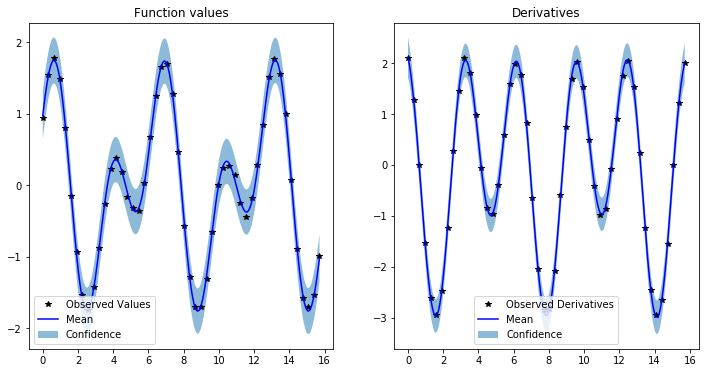

In [5]:
# Set into eval mode
model.train()
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(12, 6))

# Make predictions
with torch.no_grad(), gpytorch.settings.max_cg_iterations(50):
    test_x = torch.linspace(lb, ub, 500)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.legend(['Observed Values', 'Mean', 'Confidence'])
y1_ax.set_title('Function values')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.legend(['Observed Derivatives', 'Mean', 'Confidence'])
y2_ax.set_title('Derivatives')

None